# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- Work on some features.
- Check classification instead of regression as well - will the stock go up or down? Looks imbalanced set though...
- Maybe try predicting only 6 months in advance instead of a year.
- Maybe do a market cap cut, need to analyze companies of similar sizes
- Need to do a large parameter search for XGBoost.

In [18]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [19]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
#tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")
tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
tickers.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",6.5001,3.873322e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,FCCY,1st Constitution Bancorp (NJ),18,1.436993e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
2,SRCE,1st Source Corporation,44.82,1.159751e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN
3,ABIL,Ability Inc.,3.21,8.267722e+07,n/a,2014,Finance,Business Services,http://www.nasdaq.com/symbol/abil,NaN
4,ABM,ABM Industries Incorporated,40.86,2.270007e+09,n/a,n/a,Finance,Diversified Commercial Services,http://www.nasdaq.com/symbol/abm,NaN


## Get Data

In [28]:
#scrape financial data from Morningstar
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #delete annoying repeated columns, ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #isolate desired year
    d = d[d['index'].str.contains("%d"%year)] 
    #final additions
    d.insert(0,'Stock',stock)                              #keep stock ticker
    date = last_weekday_of_month(d['index'].values[0])
    d.insert(1,'Price',DataReader(stock,'yahoo',date,date)['Adj Close'].values[0]) #get stock price
    return d

#small helper function for getting target
def last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BM')

#scrapes data from yahoo, gets target
def get_frac_price_change(stock,date):
    last_current = last_weekday_of_month(date)
    ds = date.split('-')
    last_future = last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    current_price = DataReader(stock, 'yahoo', last_current, last_current)['Adj Close'].values[0]
    future_price = DataReader(stock, 'yahoo', last_future, last_future)['Adj Close'].values[0]
    return (future_price - current_price)/current_price
    
#simple progress bar
def progress(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item
    
#Top-level function which acquires all the data
def get_data(stocks,year):
    #create empty dataframe with available columns
    cols = get_stock_financials(stocks["Symbol"][0],year).columns
    X = pd.DataFrame(columns=cols)
    y = []
    skip = []
    for s in progress(stocks["Symbol"], len(stocks["Symbol"])/10):
        try:
            _X = get_stock_financials(s,year)
            _y = get_frac_price_change(s,_X['index'].values[0])
            if _X.shape[1] > 1 and _y: #only append if alg actually recovered data
                X = X.append(_X)
                y.append(_y)
        except:
            skip.append(s)
    X = X.set_index('Stock')
    #X = pd.to_numeric(X)
    X = X.convert_objects(convert_numeric=True)
    return X, y, skip

In [48]:
year = 2015
stocks = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
stocks = stocks.loc[stocks['MarketCap']>1e7]  #exclude stocks with small market cap

#get data - this will take a minute!
X, y, skip = get_data(stocks, year)

 0.0 0.09887359199 0.19774718398 0.29662077597 0.39549436796 0.49436795995 0.59324155194 0.69211514393 0.79098873592 0.88986232791 0.9887359199/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:76: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [19]:
#X['Debt/Equity'] = pd.to_numeric(X['Debt/Equity'])
#X = X.convert_objects(convert_numeric=True)

## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [49]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

**Deleted** Accounts Payable: NaN fraction = 0.7020
**Deleted** Accounts Receivable: NaN fraction = 0.1948
**Deleted** Accrued Liabilities: NaN fraction = 0.5785
Asset Turnover: NaN fraction = 0.0218
Asset Turnover (Average): NaN fraction = 0.0218
Book Value Per Share * USD: NaN fraction = 0.0145
**Deleted** COGS: NaN fraction = 0.8939
**Deleted** Cap Ex as a % of Sales: NaN fraction = 0.1134
**Deleted** Cap Spending USD Mil: NaN fraction = 0.1265
Cash & Short-Term Investments: NaN fraction = 0.0116
**Deleted** Cash Conversion Cycle: NaN fraction = 0.9826
**Deleted** Current Ratio: NaN fraction = 0.8270
**Deleted** Days Inventory: NaN fraction = 0.9826
**Deleted** Days Sales Outstanding: NaN fraction = 0.8488
**Deleted** Debt/Equity: NaN fraction = 0.1366
**Deleted** Dividends USD: NaN fraction = 0.2936
EBT Margin: NaN fraction = 0.0160
Earnings Per Share USD: NaN fraction = 0.0131
Financial Leverage: NaN fraction = 0.0160
Financial Leverage (Average): NaN fraction = 0.0160
**Deleted**

ValueError: Unable to parse string

In [50]:
X.columns

Index([u'Asset Turnover', u'Asset Turnover (Average)',
       u'Book Value Per Share * USD', u'Cash & Short-Term Investments',
       u'EBT Margin', u'Earnings Per Share USD', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Free Cash Flow Per Share * USD',
       u'Free Cash Flow USD Mil', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Sales %', u'Net Income USD Mil', u'Net Margin %',
       u'Operating Cash Flow USD Mil', u'Operating Income USD Mil',
       u'Operating Margin', u'Operating Margin %', u'Other', u'Price',
       u'Return on Assets %', u'Return on Equity %', u'Revenue', u'SG&A',
       u'Shares Mil', u'Total Assets', u'Total Liabilities',
       u'Total Liabilities & Equity', u'Total Stockholders' Equity', u'index'],
      dtype='object')

In [53]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   #how easily that company can turn assets into cash to pay short-term obligations
X['P/E Ratio'] = X['Price']/X['Earnings Per Share USD']                 #investors' assessment of future earnings
X['P/B Ratio'] = X['Price']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] #debt/equity ratio

#features to include for analysis
percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD','EBT Margin',
          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover']

features = percentiles + ratios

In [54]:
XX = X[features]

In [58]:
XX.head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover
Stock,,,,,,,,,,,,,,
PIH,-6.17,-3.43,-2.14,-8.6,19.79,7.48,-0.27,1.45,-8.61,2.374169,-28.333333,1.022727,0.727713,0.35
FCCY,19.88,9.47,0.90,29.2,32.00,11.92,1.07,2.14,29.20,1.110001,11.950756,1.072761,9.090817,0.05
SRCE,23.01,9.14,1.15,35.4,36.64,24.56,2.17,3.44,35.45,1.141683,13.859179,1.224528,7.058018,0.05
ABIL,28.29,129.67,23.24,34.3,17.66,0.19,0.60,-0.20,34.09,1.638270,16.500000,52.105263,1.566735,0.82
ABM,1.56,7.72,3.51,1.5,2.43,17.58,1.33,2.35,1.48,1.881822,20.846357,1.577113,1.134016,2.26


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [76]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### Best params so far
-0.111054839795
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}

In [64]:
model = xgb.XGBClassifier()
n_cv = 3
n_iter = 10     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.5,1],
    'gamma': [0,0.2,0.4],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

-0.135278055089
{'colsample_bytree': 1, 'learning_rate': 0.1, 'min_child_weight': 0.5, 'n_estimators': 1000, 'max_depth': 8, 'gamma': 0.2}


In [77]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier()
best_params={
    'learning_rate': [1e-2],
    'n_estimators':[3000],
    'max_depth': [8],
    'min_child_weight': [0.5],
    'colsample_bytree': [1],
    'gamma': [0.2],
}
final_model = GridSearchCV(model, param_grid=best_params, scoring='neg_mean_squared_error')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

-0.14184235702


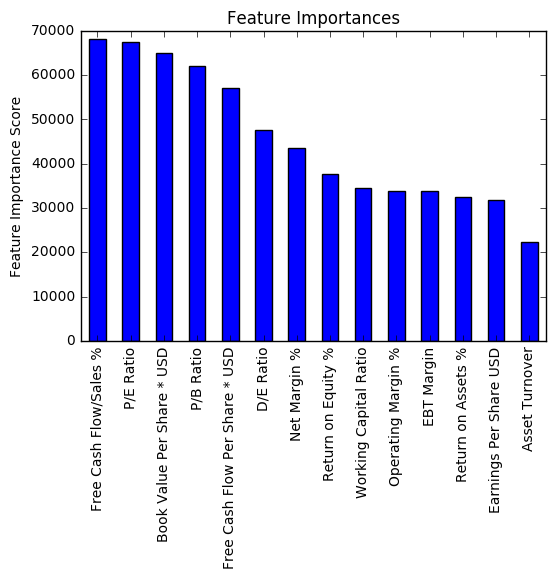

In [79]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [81]:
y_test_predict = xgb_model.predict(X_test)

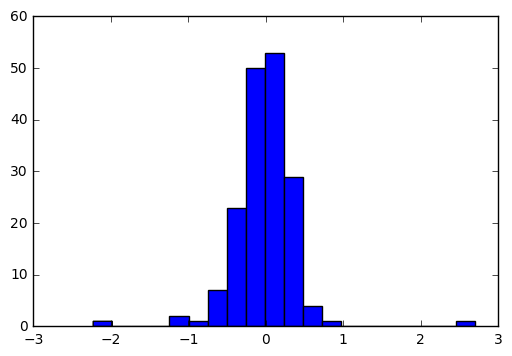

In [102]:
_,_,_ = plt.hist((y_test_predict - y_test), 20)

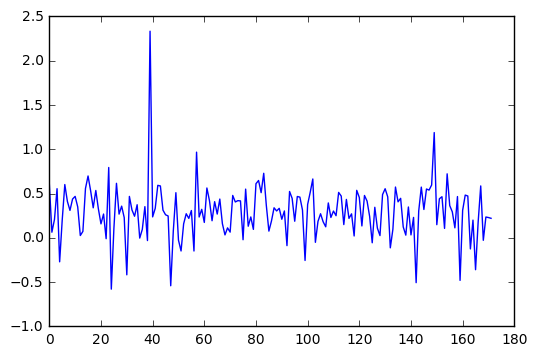

In [103]:
plt.plot(y_test)

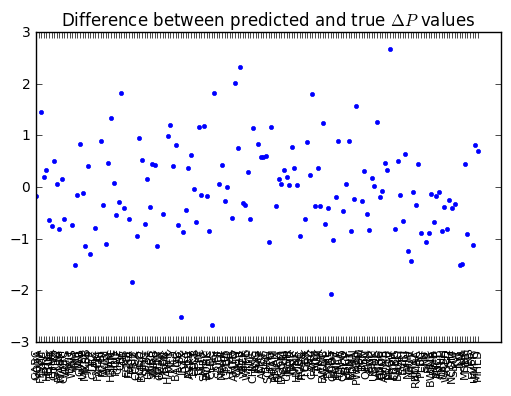

In [100]:
#plt.plot(y_test_predict, '.', label='predicted')
#plt.plot(y_test, '.', label='true')
plt.plot((y_test_predict - y_test)/y_test, '.')
plt.legend(fontsize=8, numpoints=1)
plt.xticks(range(len(y_test)), X_test.index, rotation='vertical', fontsize=8)
#plt.xlim([40,80])
plt.ylim([-3,3])
plt.title('Difference between predicted and true $\Delta P$ values');

# Extra

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [38]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [33]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [32]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [24]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()